In [83]:
import pandas as pd
import preprocess as prep
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### 주문 데이터 처리

In [46]:
ord_df = pd.read_csv("files/olist_orders_dataset.csv")

In [47]:
date_column_list = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
ord_df = prep.to_date(ord_df, date_column_list)

In [48]:
ord_df['estimated_dt'] = ord_df.apply(
    lambda row: prep.date_diff(
        row['order_purchase_timestamp'],
        row['order_estimated_delivery_date']
    ),
    axis=1  # 행 단위 적용 (필수)
)

ord_df['real_dt'] = ord_df.apply(
    lambda row: prep.date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_customer_date']
    ),
    axis=1
)

In [49]:
ord_df = prep.handle_outliers_iqr_num(ord_df)

In [50]:
ord_df.dropna(inplace=True)

<Axes: >

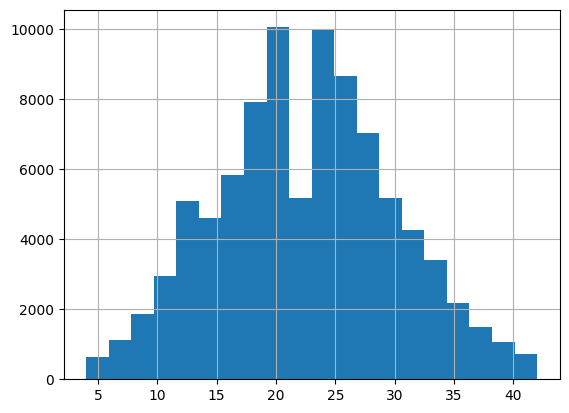

In [51]:
ord_df['estimated_dt'].hist(bins=20)

<Axes: >

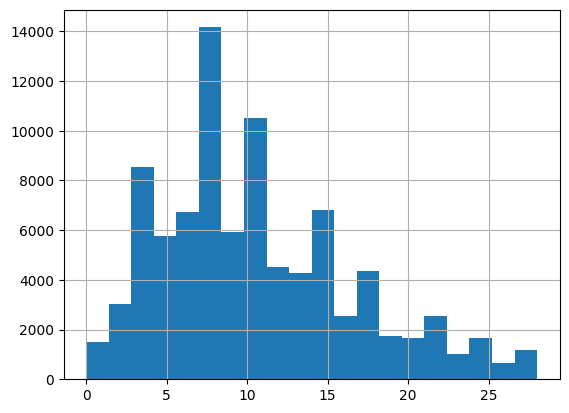

In [52]:
ord_df['real_dt'].hist(bins=20)

### ord_df['dd'] 는 예상 배송 - 실제 배송

In [53]:
ord_df['dd'] = ord_df['estimated_dt'] - ord_df['real_dt']

<Axes: >

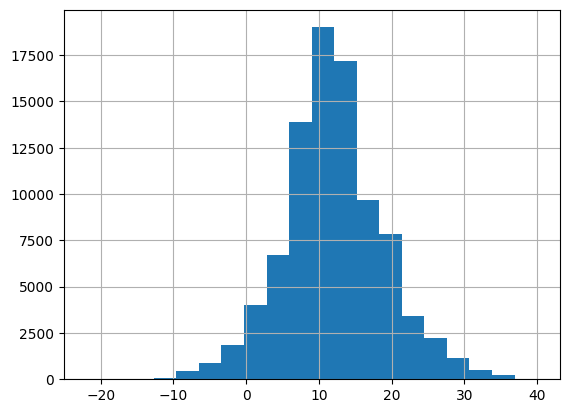

In [54]:
ord_df['dd'].hist(bins=20)

#### 리뷰 데이터 처리

In [55]:
rev_df = pd.read_csv("files/olist_order_reviews_dataset.csv")

#### rev_df['new_score']은 별점 1,2,3은 0, 4,5는 1

In [56]:
rev_df['new_score'] = rev_df['review_score'].map({1:0, 2:0, 3:0, 4:1, 5:1})

#### rev_df_c은 'order_id', 'new_score', 'review_score' 있는 데이터 프레임

In [88]:
rev_df_c = rev_df[['order_id', 'new_score', 'review_score']]
rev_df_c = rev_df_c.drop_duplicates()

In [89]:
rev_df_c

,order_id,new_score,review_score
0,73fc7af87114b39712e6da79b0a377eb,1,4
1,a548910a1c6147796b98fdf73dbeba33,1,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,5
3,658677c97b385a9be170737859d3511b,1,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,5
...,...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,1,5
99220,22ec9f0669f784db00fa86d035cf8602,1,5
99221,55d4004744368f5571d1f590031933e4,1,5
99222,7725825d039fc1f0ceb7635e3f7d9206,1,4


#### 상품 데이터 처리

In [90]:
oi_df = pd.read_csv("files/olist_order_items_dataset.csv")

In [91]:
oi_df = prep.handle_outliers_iqr_selection(oi_df, ["freight_value"])

fv_df는 "order_id"별 "freight_value"합

In [92]:
fv_df = oi_df.groupby("order_id")["freight_value"].sum().reset_index()

#### 데이터 결합

In [93]:
df = pd.merge(rev_df_c, ord_df, how='inner', on='order_id')
df = pd.merge(df, fv_df, how='inner', on='order_id')

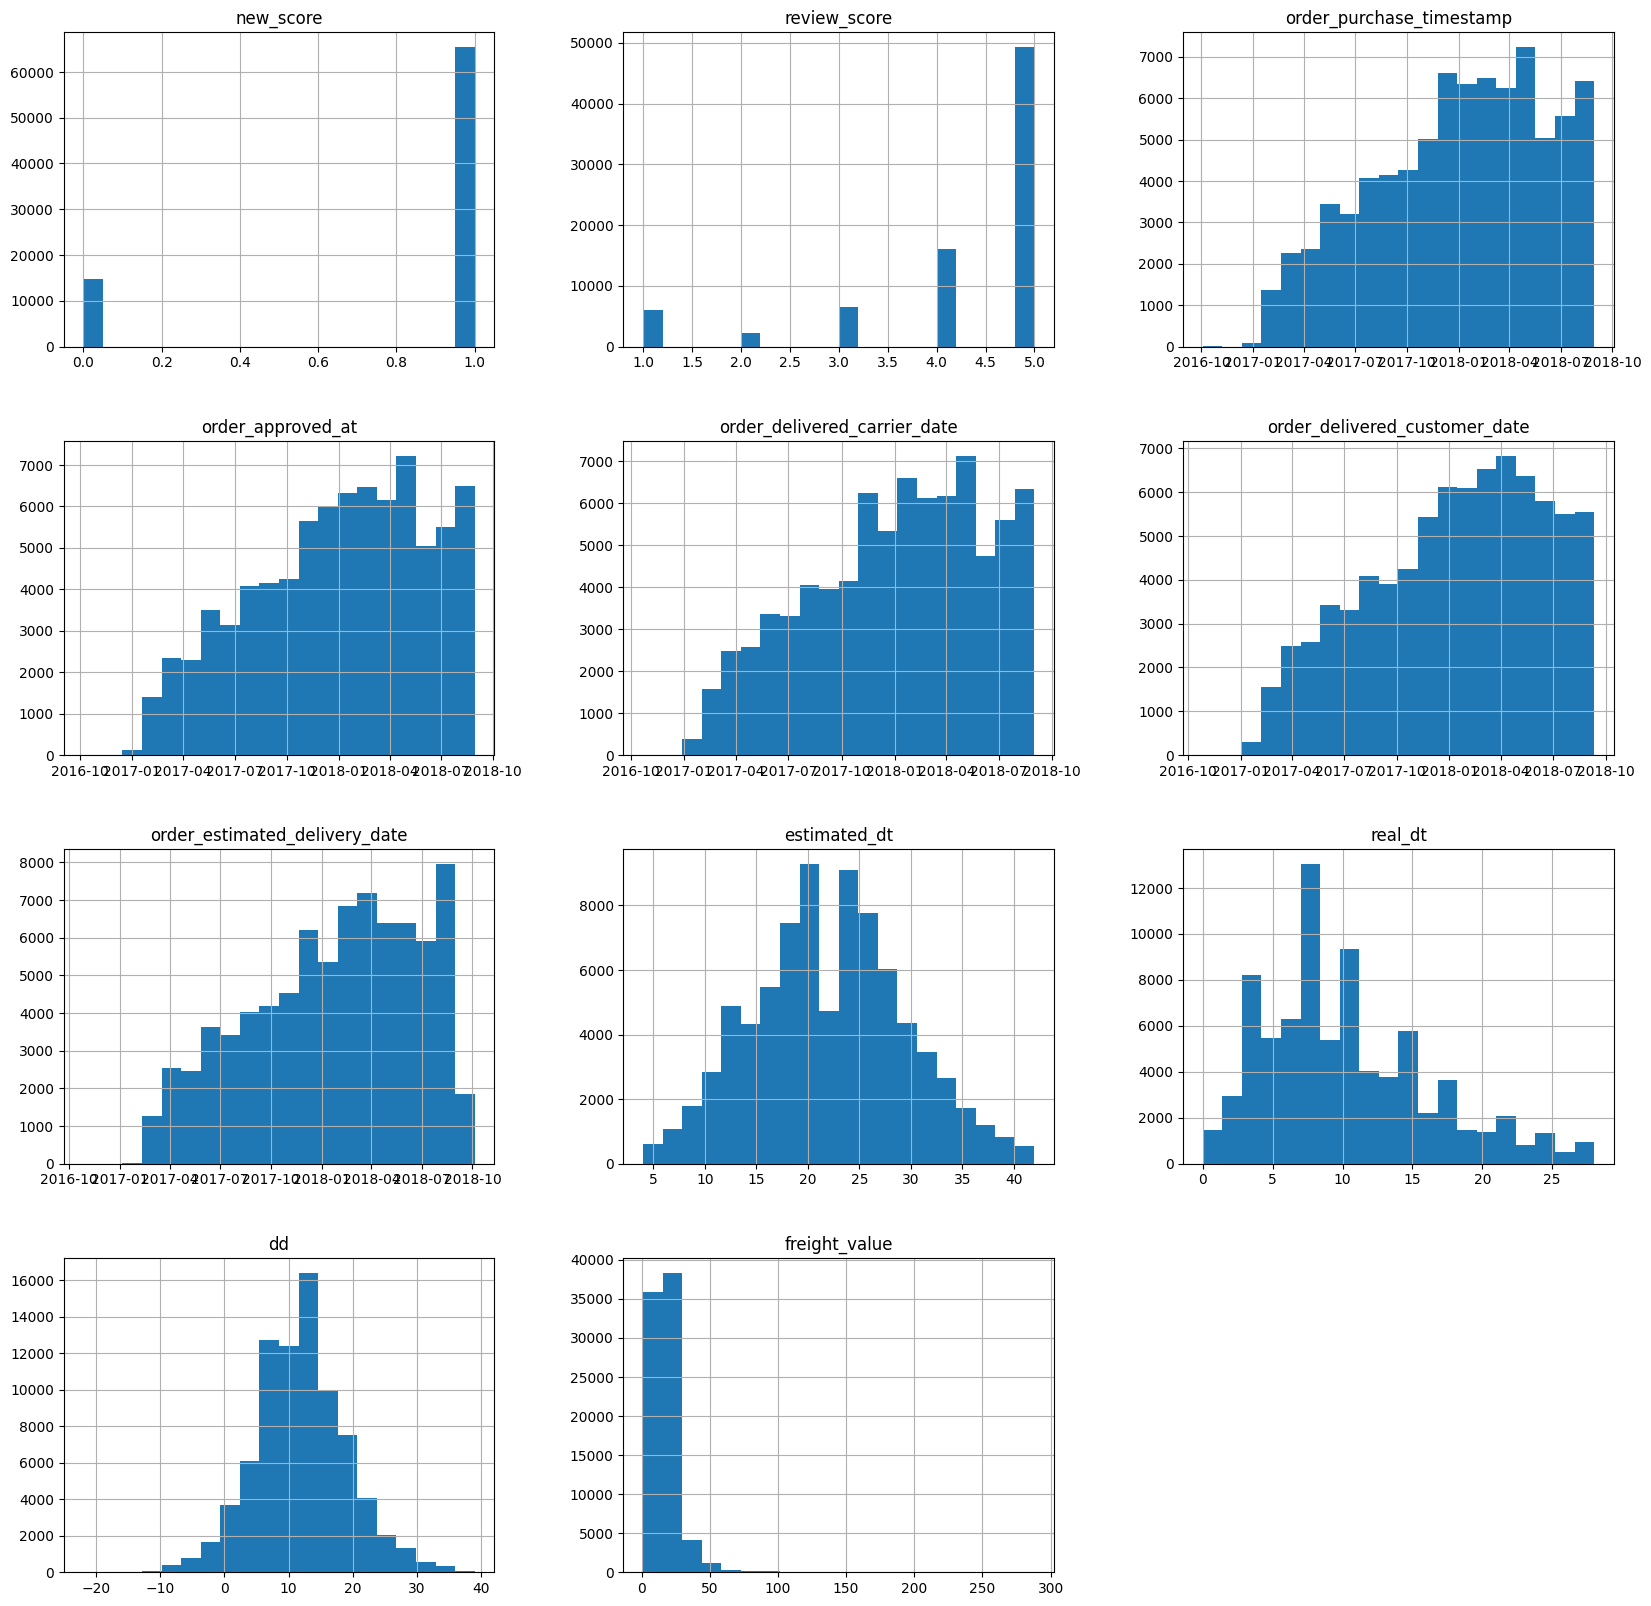

In [94]:
df.hist(bins=20, figsize=(20,20))
plt.show()

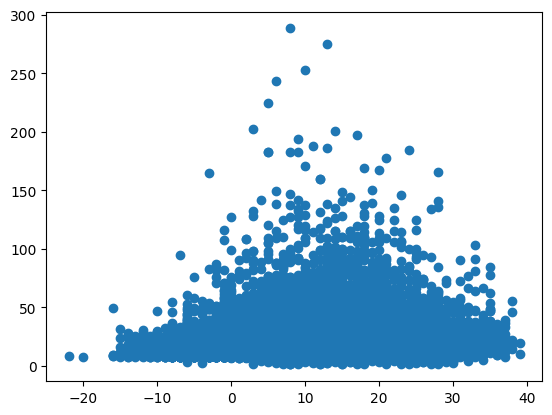

In [77]:
plt.scatter(df['dd'], df['freight_value'])

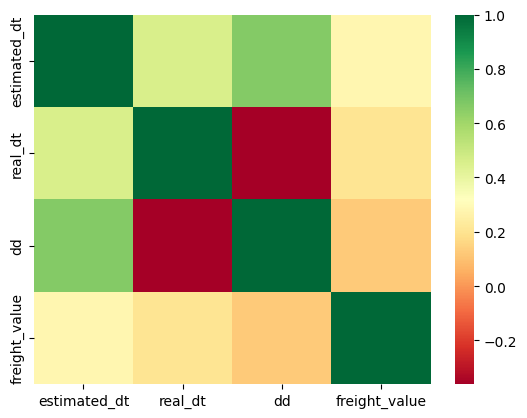

In [86]:
df_corr = df[[
    'estimated_dt', 'real_dt', 'dd', 'freight_value'
]]
corr_numeric = df_corr.corr()
sns.heatmap(corr_numeric, cmap='RdYlGn')
plt.show()

In [87]:
corr_numeric

,estimated_dt,real_dt,dd,freight_value
estimated_dt,1.000000,0.456991,0.664297,0.281496
real_dt,0.456991,1.000000,-0.361274,0.203757
dd,0.664297,-0.361274,1.000000,0.123873
freight_value,0.281496,0.203757,0.123873,1.000000


In [17]:
df_t = df[['new_score', 'dd']]

10.397934087555337
11.0


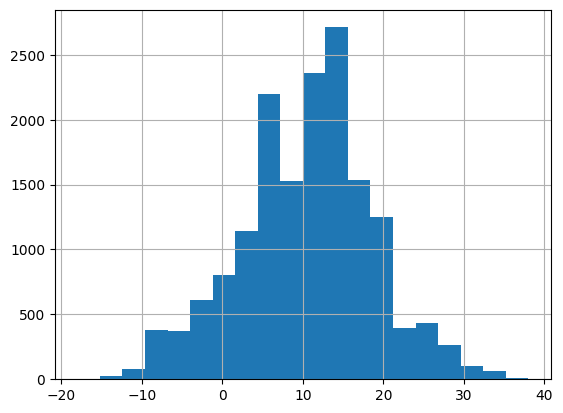

In [95]:
print(f"{df_t[df_t['new_score'] == 0]['dd'].mean()}")
print(f"{df_t[df_t['new_score'] == 0]['dd'].median()}")

df_t[df_t['new_score'] == 0]['dd'].hist(bins=20)
plt.show()

12.384828862164662
12.0


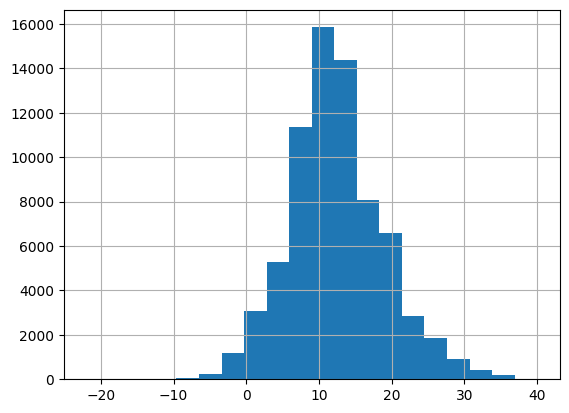

In [96]:
print(f"{df_t[df_t['new_score'] == 1]['dd'].mean()}")
print(f"{df_t[df_t['new_score'] == 1]['dd'].median()}")

df_t[df_t['new_score'] == 1]['dd'].hist(bins=20)
plt.show()

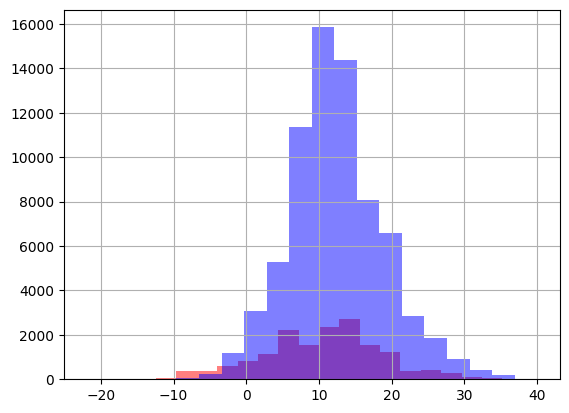

In [97]:
df_t[df_t['new_score'] == 0]['dd'].hist(bins=20, alpha=0.5, color='red')
df_t[df_t['new_score'] == 1]['dd'].hist(bins=20, alpha=0.5, color='blue')
plt.show()

#### T-Test

In [98]:
s_1 = df_t[df_t['new_score'] == 1]['dd']
s_0 = df_t[df_t['new_score'] == 0]['dd']

In [29]:
stat_0, p_0 = stats.shapiro(s_0)
stat_1, p_1 = stats.shapiro(s_1)
print(f"""
정규성 검정 결과
======================
부정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : {stat_0:3f}
p-value: {p_0:3f}
======================
긍정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : {stat_1:3f}
p-value: {p_1:3f}
======================

정규성을 만족하지 않는다.
""")


정규성 검정 결과
부정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : 0.994032
p-value: 0.000000
긍정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : 0.991724
p-value: 0.000000

정규성을 만족하지 않는다.



In [23]:
stat, p = stats.levene(s_0, s_1)
print(f"""
등분산 검정 결과
======================
검정통계량 : {stat:3f}
p-value: {p:3f}
======================

등분선성을 만족하지 않는다.
""")


등분산 검정 결과
검정통계량 : 997.911599
p-value: 0.000000

등분선성을 만족하지 않는다.



In [24]:
tstat, pval = stats.ttest_ind(s_0, s_1, equal_var=False)
print(f"""
T 검정 결과
======================
T 검정통계량 : {tstat:.3f}
p-value : {pval:.3f}
======================
""")
if pval < 0.05:
    print("두 집단의 차이가 존재한다")
else:
    print("두 집단의 차이가 존재하지 않는다.")


T 검정 결과
T 검정통계량 : -28.626
p-value : 0.000

두 집단의 차이가 존재한다


In [25]:
stat, pval = stats.mannwhitneyu(s_0, s_1, alternative='two-sided')
print(f"""
Mann-Whitney U 검정 결과
======================
검정통계량 : {stat:.3f}
p-value : {pval:.3f}
======================
""")
if pval < 0.05:
    print("두 집단의 차이가 존재한다")
else:
    print("두 집단의 차이가 존재하지 않는다.")


Mann-Whitney U 검정 결과
검정통계량 : 512978637.000
p-value : 0.000

두 집단의 차이가 존재한다


# 카이제곱

In [ ]:
df_t['dd_g'] = 0
df_t.loc[df_t['dd'] > 0, 'dd_g'] = 1 #예상 배송 > 실제 배송이면 'dd_g'값이 1(긍정)
df_crosstab = pd.crosstab(df_t['dd_g'], df_t['new_score'])

In [31]:
chi2, pval, dof, expected = stats.chi2_contingency(df_crosstab)
print("χ² (Country × High/Low):", chi2, "p:", pval, "dof:", dof)

χ² (Country × High/Low): 2234.5432235503545 p: 0.0 dof: 1


In [100]:
df_1 = df[df['dd'] < 0]
df_2 = df[df['dd'] >= 0]

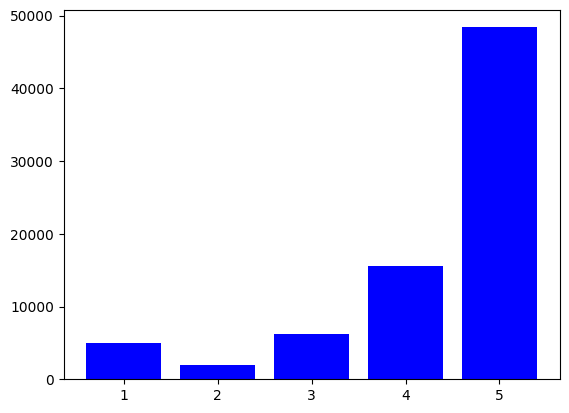

In [108]:
df_2_bar = df_2.groupby("review_score").size()
plt.bar(df_2_bar.index, df_2_bar.values, color='b')
plt.show()

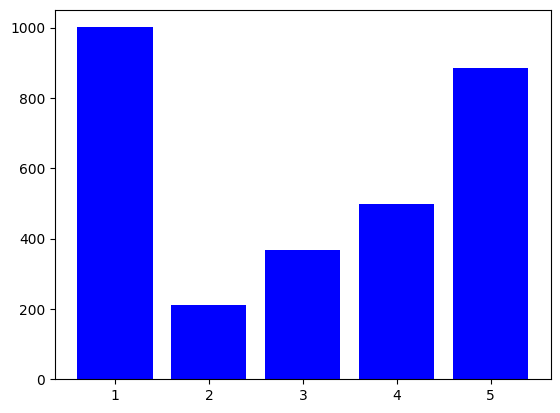

In [107]:
df_1_bar = df_1.groupby("review_score").size()
plt.bar(df_1_bar.index, df_1_bar.values, color='b')
plt.show()